##Time Series Forecasting Task: Stock Price Prediction
The task at hand is a classic example of time series forecasting, where the goal is to predict future values based on previously observed values. Specifically, we aim to predict the future stock prices of Apple Inc. (AAPL) using historical stock price data.

The primary goal is to develop a predictive model that can accurately forecast future stock prices. By analyzing patterns and trends in historical data, the model will attempt to predict the closing prices of the stock for the upcoming days.

## Challenges in Time Series Forecasting
- **Temporal Dependency**: Unlike traditional regression tasks, time series data points are dependent on each other over time. Capturing this temporal dependency is crucial for accurate predictions.
- **Trend and Seasonality**: Stock prices often exhibit trends (long-term increase or decrease) and seasonality (repeating patterns over specific periods). Identifying and modeling these components is essential.
- **Noise and Volatility**: Financial data is typically noisy and can be highly volatile due to market conditions, economic events, and other external factors.
- **Data Stationarity**: Many statistical models assume that the time series data is stationary, meaning its statistical properties do not change over time. Non-stationary data needs to be transformed for effective modeling.

##Methodology
- **Data Collection**: Gather historical stock price data, which includes daily prices such as open, high, low, close, and volume. For this task, we focus on the closing prices.
- **Data Preprocessing**: Normalize the data to ensure it is on a consistent scale, making it easier for the model to learn. Also, create sequences of historical prices to use as inputs for the model.
- **Model Selection**: Use a GRU (Gated Recurrent Unit) neural network, a type of RNN (Recurrent Neural Network) that is effective in capturing temporal dependencies in sequential data.

##Installing yfinance
This cell installs the yfinance library, which is used to download historical market data from Yahoo Finance. This library will be used later to fetch stock prices.



In [ ]:
!pip install yfinance

## Importing Required Libraries
This cell imports the necessary libraries needed for data manipulation, visualization, and building neural networks. The libraries include NumPy for numerical operations, Matplotlib for plotting, Pandas for data handling, PyTorch for neural network creation, and Scikit-Learn for data preprocessing.

In [ ]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

##Loading and Preparing the Dataset
When we run the first line, the library fetches the historical stock data for Apple Inc. (AAPL) from Yahoo Finance for the date range specified, which is from January 1, 2010, to January 1, 2021. This data includes various columns such as 'Open', 'High', 'Low', 'Close', 'Volume', and 'Adj Close'. The data is returned as a Pandas DataFrame. The closing prices are extracted from the DataFrame and converted to a NumPy array of floats for numerical computations. Next, the data is normalized to the range [-1, 1] using MinMaxScaler, which helps in improving the performance and convergence rate of the neural network.

In [ ]:
# Download historical stock data for Apple (AAPL) from Yahoo Finance
df = yf.download('AAPL', start='2010-01-01', end='2021-01-01')

# Extract the closing prices
data = df['Close'].values.astype(float)

# Normalize the closing prices and reshape the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

## Creating Sequences for Training
The function create_sequences is defined to generate sequences of length 30 from the normalized data, where each sequence is used to predict the next value. The data is then split into training and testing sets, with 80% used for training and 20% for testing. Finally, the training and testing data are converted to PyTorch tensors, making them ready for model training and evaluation. This comprehensive preprocessing ensures that the data is appropriately formatted and scaled for the GRU model.

In [ ]:
def create_sequences(data, seq_length):
  # Initialize a list to store input sequences
  xs = []
  # Initialize a list to store target values
  ys = []
  for i in range(len(data)-seq_length):
    # Extract a sequence of length seq_length
    x = data[i:i+seq_length]
    # Extract the next data point
    y = data[i+seq_length]
    # Append the sequence to the input list
    xs.append(x)
    # Append the target value to the target list
    ys.append(y)
  return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data_normalized, seq_length)

# Define the training set size and Split the input sequences and theis related target values into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

##Defining the GRU Model
In this cell, we define the architecture of the GRU (Gated Recurrent Unit) model using PyTorch's nn.Module. The GRUModel class is created, and the __init__ method initializes the parameters of the model, including input_size, hidden_size, output_size, and num_layers. The GRU layer is defined with the specified input size, hidden size, and number of layers. Additionally, a fully connected layer (nn.Linear) is added to map the GRU outputs to the desired output size. The forward method defines the forward pass of the model, where an initial hidden state is created, the input data is passed through the GRU layer, and the output of the last time step is passed through the fully connected layer to generate the final prediction. This model architecture is designed to capture temporal dependencies in the stock price data, making it well-suited for time series forecasting.


In [ ]:
# Define a GRU model class inheriting from nn.Module
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout_prob=0.2):
      super(GRUModel, self).__init__()
      self.hidden_layer_size = hidden_layer_size
      self.num_layers = num_layers
      # Define the GRU layer
      self.gru = nn.GRU(input_size, hidden_layer_size, num_layers, dropout=dropout_prob)
      # Define the fully connected layer
      self.linear = nn.Linear(hidden_layer_size, output_size)
      # Initialize the hidden state
      self.hidden_cell = torch.zeros(self.num_layers, 1, self.hidden_layer_size)

    def forward(self, input_seq):
      # Initialize the hidden state
      reshaped_input = input_seq.view(len(input_seq), 1, -1)
      # Pass the input through the GRU layer
      gru_out, self.hidden_cell = self.gru(reshaped_input, self.hidden_cell)
      # Pass the output of the last time step through the fully connected layer
      predictions = self.linear(gru_out.view(len(input_seq), -1))
      return predictions[-1]

## Initializing the Model, Loss Function, and Optimizer
In this cell, we initialize the GRU model with specific hyperparameters. The input_size is set to 1, as we are using a single feature (the closing price). The hidden_size is set to 100, indicating the number of features in the hidden state. The output_size is set to 1, as we are predicting a single value (the next closing price). The num_layers is set to 2, indicating that the GRU will have two stacked layers. Dropout rate is set to 0.2 to prevent the model from overfitting.

The mean squared error (MSELoss) is chosen as the loss function, which measures the average squared difference between the predicted and actual values. The Adam optimizer is initialized with a learning rate of 0.001, which will be used to update the model parameters during training. This setup prepares the model for the training process, defining how it will learn from the data.

In [ ]:
# Define GRU model
model = GRUModel(input_size=1, hidden_layer_size=100, output_size=1, num_layers=2, dropout_prob=0.2)

# Define MSE as loss function and Adam as optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the model
This cell handles the training process of the GRU model. The model is trained for a specified number of epochs (num_epochs set to 20). For each epoch, the model is set to training mode using model.train(). The training data is loaded in batches using train_loader. For each batch, the optimizer gradients are zeroed, the model makes predictions, the loss is computed, and the loss is backpropagated. The optimizer then updates the model parameters. After each epoch, the model is set to evaluation mode using model.eval(), and the validation loss is computed using val_loader. This validation step ensures that the model's performance is monitored on unseen data, helping to prevent overfitting. The average validation loss is printed at the end of each epoch, providing insight into the model's progress and effectiveness.

Then, The model is set to evaluation mode using model.eval() to ensure that it does not update its parameters during testing. The evaluation is done within a torch.no_grad() context to prevent gradient computation, making the process faster and more memory-efficient. The test data is loaded in batches using test_loader. For each batch, the model makes predictions, and the loss is computed using the mean squared error criterion. The cumulative test loss is computed by summing the loss for each batch. Finally, the average test loss is printed, providing an unbiased estimate of the model's performance on unseen data. This step is crucial to verify that the model generalizes well and is ready for real-world predictions.

In the code, we also used early stopping and model checkpointing are implemented to enhance the training process's efficiency and effectiveness. Early stopping monitors the validation loss and halts training if it stops improving, thereby preventing overfitting and ensuring that the model generalizes well to unseen data. Model checkpointing complements this by saving the model's parameters whenever a new lowest validation loss is observed. Specifically, during each epoch, the current epoch's validation loss (epoch_test_loss) is compared with the best validation loss recorded so far (best_test_loss). If the current validation loss is lower, best_test_loss is updated to this new value, and the current epoch is noted as best_epoch. Consequently, the model's state dictionary, which contains its parameters, is saved to a file named best_model.pth in the specified directory (model_dir). This process ensures that even if training is interrupted later, the best-performing model is preserved, thus facilitating better performance on future data predictions and avoiding overfitting.

In [ ]:
epochs = 200

for epoch in range(epochs):
  # train mode
  model.train()
  for seq, labels in zip(X_train, y_train):
    # clear the gradients of all optimized parameters
    optimizer.zero_grad()
    # reset the hidden cell state of the model to zeros to prevent information leakage between sequences
    model.hidden_cell = torch.zeros(model.num_layers, 1, model.hidden_layer_size)
    # passe the input test sequence through the model to obtain the predictions
    pred_train = model(seq)
    # compute the loss between the model's predictions and the actual labels
    train_loss = loss_function(pred_train, labels)
    # compute the gradients of the loss with respect to the model weights (backpropagation)
    train_loss.backward()
    # update the model weights based on the computed gradients to minimize the loss
    optimizer.step()

  # eval mode
  model.eval()
  with torch.no_grad():
    for seq, labels in zip(X_test, y_test):
      model.hidden_cell = torch.zeros(model.num_layers, 1, model.hidden_layer_size)
      pred_test = model(seq)
      test_loss = loss_function(pred_test, labels)

  if epoch % 10 == 0:
      print(f'epoch: {epoch:3} train loss: {train_loss.item():10.8f}, test loss: {test_loss.item():10.8f}')

epoch:   0 train loss: 0.00018306, test loss: 1.29208291
epoch:  10 train loss: 0.00033145, test loss: 1.27119100
epoch:  20 train loss: 0.00001995, test loss: 1.67265236
epoch:  30 train loss: 0.00024924, test loss: 1.44777048
epoch:  40 train loss: 0.00025148, test loss: 1.21561599
epoch:  50 train loss: 0.00115227, test loss: 0.51763976
epoch:  60 train loss: 0.00022703, test loss: 66.68912506
epoch:  70 train loss: 0.00070108, test loss: 4.93643475
epoch:  80 train loss: 0.00054829, test loss: 0.03229512
epoch:  90 train loss: 0.00011294, test loss: 0.41429245
epoch: 100 train loss: 0.00030307, test loss: 1.41765702
epoch: 110 train loss: 0.00021106, test loss: 1.15934575
epoch: 120 train loss: 0.00051082, test loss: 1.68679190
epoch: 130 train loss: 0.00000672, test loss: 1.20035791
epoch: 140 train loss: 0.00046130, test loss: 1.22890282
epoch: 150 train loss: 0.00025972, test loss: 0.71944016
epoch: 160 train loss: 0.00014859, test loss: 1.30290008
epoch: 170 train loss: 0.00032

In [ ]:
# Final loss of final batch
print(f'epoch: {epoch:3} train loss: {train_loss.item():10.8f}, test loss: {test_loss.item():10.8f}')

epoch: 199 train loss: 0.00025594, test loss: 0.74428427


##Making Predictions
In this cell, we demonstrate how to use the trained GRU model to make predictions on new data. The model is set to evaluation mode using model.eval(), ensuring that no gradients are computed, and the model's parameters remain unchanged. Within a torch.no_grad() context, a sample input data is converted to a PyTorch tensor. The model then makes predictions based on this input data. The predicted values are printed, showcasing the model's ability to forecast future stock prices. This step illustrates the practical application of the trained model, allowing us to make informed predictions based on historical data.

In [ ]:
# Set the model to evaluation mode
model.eval()

# list to save train preds
train_predictions = []

for seq in X_train:
  # Ensure no gradients are calculated
  with torch.no_grad():
    # Reset the hidden cell state
    model.hidden_cell = torch.zeros(model.num_layers, 1, model.hidden_layer_size)
    # # Pass the sequence through the model and store the prediction
    train_predictions.append(model(seq).item())

# list to save test preds
test_predictions = []
# Loop through each test sequence to generate predictions
for seq in X_test:
    with torch.no_grad():
        model.hidden_cell = torch.zeros(model.num_layers, 1, model.hidden_layer_size)
        test_predictions.append(model(seq).item())

In [ ]:
# Inverse transform the scaled train/test predictions back to the original scale
train_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Convert y_train/y_test from a PyTorch tensor to a NumPy array and reshape it for the inverse transform
y_train = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

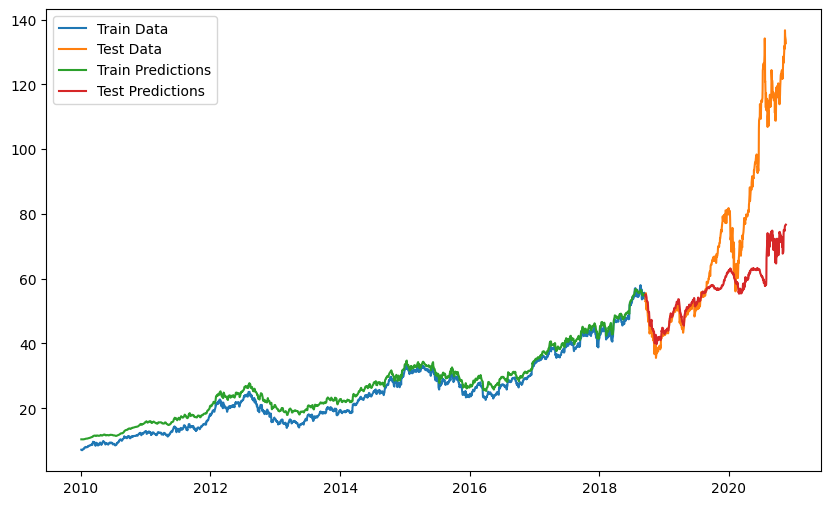

In [ ]:
plt.figure(figsize=(10,6))

# Plot the actual training data
plt.plot(df.index[:len(y_train)], y_train, label='Train Data')
# Plot the actual test data
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Test Data')

# Plot the model's predictions for the training data
plt.plot(df.index[:len(train_predictions)], train_predictions, label='Train Predictions')
# Plot the model's predictions for the test data
plt.plot(df.index[len(train_predictions):len(train_predictions)+len(test_predictions)],
         test_predictions, label='Test Predictions')

plt.legend()
plt.show()